# 5 Delta hedge

### Using QuantLib for Delta Hedging Simulation

Delta hedging is a risk management strategy that aims to reduce, or hedge, the directional risk associated with price movements in the underlying asset. The hedge is achieved by taking an offsetting position in a related derivative, such as options. This notebook demonstrates how to perform delta hedging using the QuantLib library.


In [1]:
import sys
import os

import pandas as pd


current_path = os.getcwd()  # Get current working directory
print("Current Path:", current_path)
current_path = current_path.replace('/samples', '')
print(sys.path)  # Display all module search paths
sys.path.append(current_path)  # Add custom path
print(sys.path)  # Display updated module search paths


Current Path: /Users/yang/PycharmProjects/Option/samples
['/Users/yang/PycharmProjects/Option/samples', '/Users/yang/PycharmProjects/Option', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/pydev', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/jupyter_debug', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '/opt/anaconda3/lib/python3.12/site-packages/aeosa']
['/Users/yang/PycharmProjects/Option/samples', '/Users/yang/PycharmProjects/Option', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/pydev', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/jupyter_debug', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '/opt/anaconda3/lib/python3.12/site-packages/aeosa', '/Users/yang/PycharmProjects/Option']


In [2]:
# Import necessary libraries
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt
import time

from src.utils import plot_fig
from src.QlCalendar import QlCalendar
from src.QlStocks import QlStocks
from src.QlEuropeanOptions import QlEuropeanOptions


In [3]:
# Initialize model parameters for delta hedging simulation

S0 = 100.0  # Initial stock price
V0 = 0.04  # Initial volatility
kappa = 2.0  # Mean reversion speed of volatility
theta = 0.04  # Long-term mean of volatility
sigma = 0.3  # Volatility of volatility
rho = -0.7  # Correlation between price and volatility
r = 0.05  # Risk-free rate
strike = 100.0  # Option strike price

stock_code = 'STCK'

T = 1
optionType = "call"
steps = 252  # Number of time steps (trading days)


In [4]:
# Set up QuantLib calendar and calculate maturity date
# Uses Business252 day count convention for financial calculations
start_date = ql.Date(3, 1, 2023)
ql_calendar = QlCalendar(
    init_date=start_date,
    init_risk_free_rate=r,
    # qlDayCounter=ql.Business252,
)

end_date = ql_calendar.cal_date_advance(times=steps, time_unit='days')


In [5]:
# Verify date calculations between start and maturity
print("Maturity Date:", end_date)
print("Days between start and end:", ql_calendar.calendar.businessDaysBetween(start_date, end_date))


Maturity Date: January 10th, 2024
Days between start and end: 252


In [6]:
# Initialize Black-Scholes stock model and European call option
ql_stocks = QlStocks(ql_calendar)
ql_stocks.add_heston(codes=stock_code,
                     stock_prices=S0,
                     v0=V0,
                     kappa=kappa,
                     theta=theta,
                     rho=rho,
                     sigma=sigma,
                     dividend_rates=0.0,
                     )
stock_1 = ql_stocks.stock(stock_code)

ql_options = QlEuropeanOptions(stock_1)
ql_options.add_options(
    optionType,
    strike_prices=strike,
    maturity_dates=end_date
)


codes                types  strike  maturity          
STCK240110C00100000  call   100.0   January 10th, 2024    <QuantLib.QuantLib.EuropeanOption; proxy of <S...
Name: options, dtype: object

In [7]:
# Calculate initial option price and delta using analytic engine
code = ql_options.options_df.index[0][0]
call = ql_options.option(code)
call.analytic_engine()

call_price0 = call.NPV()
delta0 = call.delta_numerical()
print(call_price0, delta0)


10.51753271945904 0.693021748899092


## Delta Hedge Simulation Process

### Initial State (t=0)
1. **Option Account**:
   - Value: `option_account[0] = call_prices[0] * option_qty`
   - Where `call_prices[0]` is initial call price, `option_qty` is constant (1)
2. **Underlying Hedge**:
   - Quantity: `stock_qty[0] = - call_delta[0]`
   - Value: `stock_account[0] = stock_qty[0] * stock_prices[0]`
3. **Cash Account**:
   - Initial funding: `cash_account[0] = - (stock_account[0] + option_account[0])`

### Rebalancing Process (t > 0)
1. **Delta Adjustment**:
   - Quantity change: `delta_qty_change = (call_delta[i] - call_delta[i-1])`
   - Cost: `rebalance_cost = delta_qty_change * stock_prices[i]`
2. **Cash Account Update**:
   - `cash_account[i] = cash_account[i-1] * exp(r * dt) - rebalance_cost`
3. **Portfolio Tracking**:
   - Option value: `option_account[i] = call_prices[i] * option_qty`
   - Stock value: `stock_account[i] = -call_delta[i] * stock_prices[i]`
   - PnL: `pnl = stock_account + cash_account`


使用步数: 252 步
timesteps: 252, Time length(per year): 1.0191780821917809start_date: January 3rd, 2023 end_date: January 10th, 2024
(253, 1000)


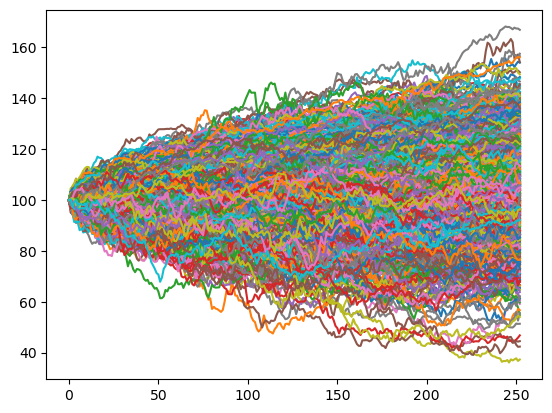

In [8]:
# Load simulated stock price paths (1000 scenarios)
paths = 1000
# stock_prices = pd.read_csv('../data/random_1000.csv', index_col=0)
# stock_prices = stock_prices.values
stock_prices = stock_1.stock_paths(paths, steps).T
plt.plot(stock_prices)
print(stock_prices.shape)


In [9]:
# Display statistics for final stock prices
print(stock_prices[-1].max(), stock_prices[-1].min(),
      stock_prices[-1].mean(), stock_prices[-1].std())


166.92871728734437 37.31014964405064 105.4944778064728 19.70423963525123


In [10]:
# Initialize arrays for tracking hedge components
ql_calendar.set_today(start_date)
dt = 1 / steps

option_qty = 1
stock_qty = np.zeros((steps, paths))

call_prices = np.zeros((steps, paths))
call_delta = np.zeros((steps, paths))

option_account = np.zeros((steps, paths))
stock_account = np.zeros((steps, paths))
cash_account = np.zeros((steps, paths))


In [11]:
# Set initial hedge positions (t=0)
today_prices = stock_prices[0]
today_call = call.NPV_multi(today_prices)
today_delta = call.delta_numerical_multi(today_prices)

call_prices[0] = today_call
call_delta[0] = today_delta
stock_qty[0] = today_delta
stock_account[0] = - today_delta * today_prices
option_account[0] = option_qty * today_call
cash_account[0] = - (stock_account[0] + option_account[0])


In [12]:
# Execute delta hedging process across all paths
t0 = time.time()
for i in np.arange(1, steps):
    today_prices = stock_prices[i]
    past_delta = call_delta[i - 1]

    # Update option metrics
    today_call = call.NPV_multi(today_prices)
    today_delta = call.delta_numerical_multi(today_prices)

    # Record current state
    call_prices[i] = today_call
    call_delta[i] = today_delta
    stock_qty[i] = - today_delta
    stock_account[i] = - today_delta * today_prices

    # Update cash account with rebalancing cost
    cash_account[i] = cash_account[i - 1] * (np.exp(r * dt)) - (-today_delta + past_delta) * today_prices

    # Advance calendar
    ql_calendar.to_next_trading_date()

# Calculate final PnL
option_account = call_prices * option_qty
pnl = option_account + stock_account + cash_account

print(f"Hedging completed in {time.time() - t0:.2f} seconds")


Hedging completed in 61.77 seconds


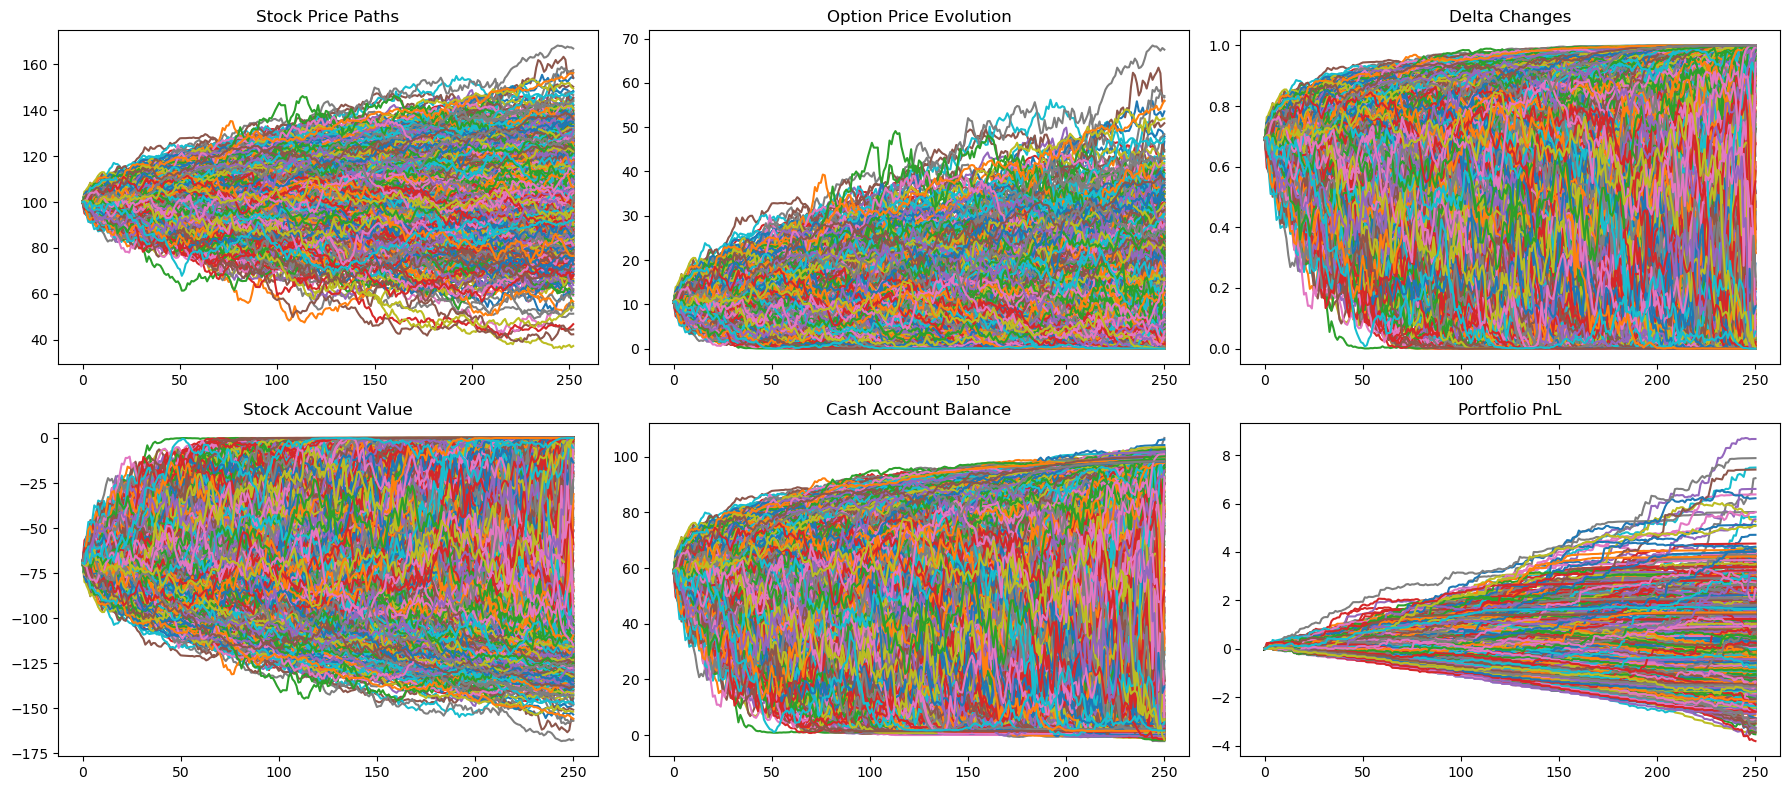

In [13]:
# Visualize hedging results across all components
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

ax[0, 0].plot(stock_prices)
ax[0, 0].set_title('Stock Price Paths')

ax[0, 1].plot(call_prices[:-1])
ax[0, 1].set_title('Option Price Evolution')

ax[0, 2].plot(call_delta[:-1])
ax[0, 2].set_title('Delta Changes')

ax[1, 0].plot(stock_account[:-1])
ax[1, 0].set_title('Stock Account Value')

ax[1, 1].plot(cash_account[:-1])
ax[1, 1].set_title('Cash Account Balance')

ax[1, 2].plot(pnl[:-1])
ax[1, 2].set_title('Portfolio PnL')

plt.tight_layout()
plt.show()


In [14]:
# Calculate average PnL across all paths
print(f"Average PnL: {pnl.mean():.2f}")


Average PnL: 0.02


## Delta Hedging Simulation Analysis

#### Profit Distribution Visualization
#### Buyer vs Seller Profit Calculation

In [33]:
# Calculate buyer and seller profits for all paths
# Buyer profit is simply the option account value at maturity (option_account[-1])
# Seller profit depends on whether the option is exercised (stock price > strike)
buyer_profits = np.zeros(paths)
seller_profits = np.zeros(paths)

for i in range(paths):
    # Buyer's profit: max(option_account[-1,i] - option_account[0,i], -option_account[0,i])
    buyer_profits[i] = max(option_account[-1, i] - option_account[0, i], -option_account[0, i])

    # Seller's profit calculation depends on exercise scenario
    if stock_prices[-1, i] > strike:
        # If exercised: cash_account + strike received
        seller_profits[i] = -cash_account[-1, i] + strike
    else:
        # If not exercised: stock_account + cash_account
        seller_profits[i] = -stock_account[-1, i] - cash_account[-1, i]

total_profit = buyer_profits - seller_profits

# Calculate statistics for display
avg_buyer_profit = np.mean(buyer_profits)
avg_seller_profit = np.mean(seller_profits)
std_buyer_profit = np.std(buyer_profits)
std_seller_profit = np.std(seller_profits)
avg_total_profit = np.mean(total_profit)
std_total_profit = np.std(total_profit)


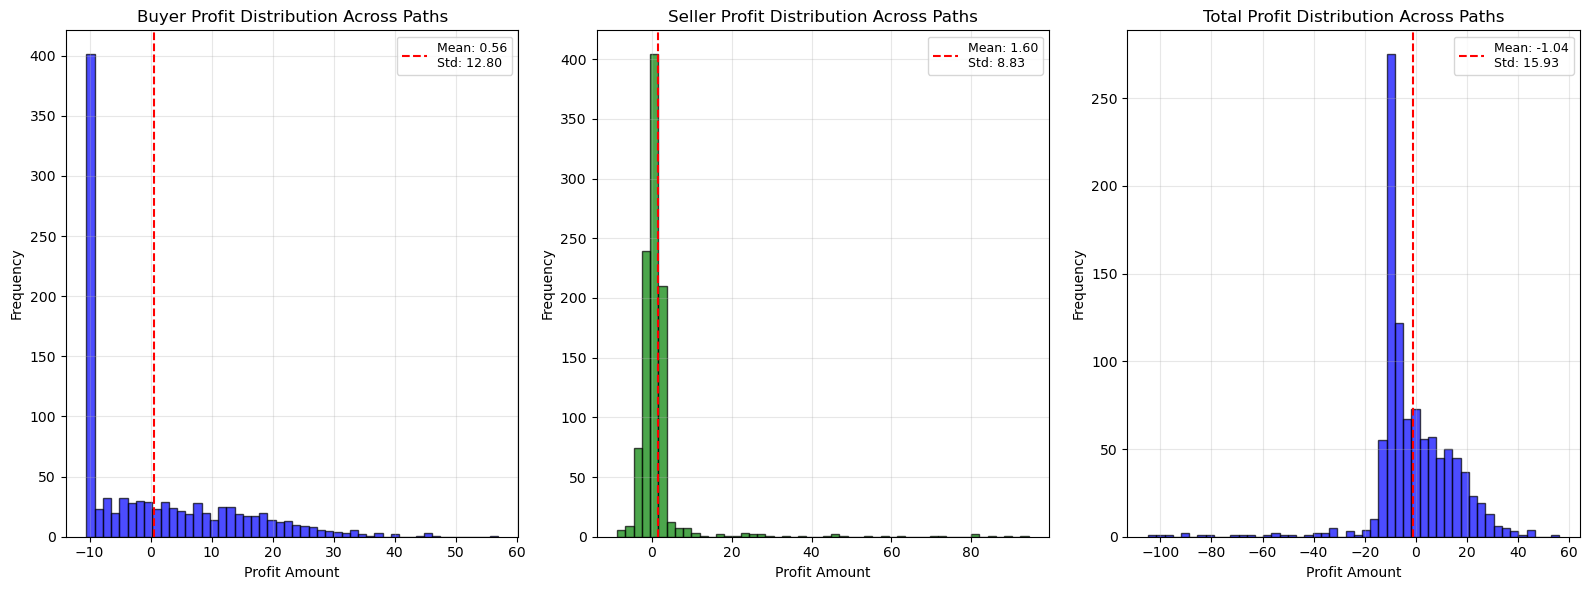

In [36]:
# Create figure with two subplots for buyer and seller profits
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# Buyer profits histogram
ax1.hist(buyer_profits, bins=50, color='blue', alpha=0.7, edgecolor='black')
ax1.axvline(x=avg_buyer_profit, color='red', linestyle='--',
            label=f'Mean: {avg_buyer_profit:.2f}\nStd: {std_buyer_profit:.2f}')
ax1.set_title('Buyer Profit Distribution Across Paths', fontsize=12)
ax1.set_xlabel('Profit Amount', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Seller profits histogram
ax2.hist(seller_profits, bins=50, color='green', alpha=0.7, edgecolor='black')
ax2.axvline(x=avg_seller_profit, color='red', linestyle='--',
            label=f'Mean: {avg_seller_profit:.2f}\nStd: {std_seller_profit:.2f}')
ax2.set_title('Seller Profit Distribution Across Paths', fontsize=12)
ax2.set_xlabel('Profit Amount', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Total profits histogram
ax3.hist(total_profit, bins=50, color='blue', alpha=0.7, edgecolor='black')
ax3.axvline(x=avg_total_profit, color='red', linestyle='--',
            label=f'Mean: {avg_total_profit:.2f}\nStd: {std_total_profit:.2f}')
ax3.set_title('Total Profit Distribution Across Paths', fontsize=12)
ax3.set_xlabel('Profit Amount', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [17]:
# Print summary statistics
print("Buyer Profit Summary:")
print(f"  Average: {avg_buyer_profit:.2f}")
print(f"  Standard Deviation: {std_buyer_profit:.2f}")
print(f"  Minimum: {np.min(buyer_profits):.2f}")
print(f"  Maximum: {np.max(buyer_profits):.2f}")
print(f"  Median: {np.median(buyer_profits):.2f}")

print("\nSeller Profit Summary:")
print(f"  Average: {avg_seller_profit:.2f}")
print(f"  Standard Deviation: {std_seller_profit:.2f}")
print(f"  Minimum: {np.min(seller_profits):.2f}")
print(f"  Maximum: {np.max(seller_profits):.2f}")
print(f"  Median: {np.median(seller_profits):.2f}")


Buyer Profit Summary:
  Average: 0.56
  Standard Deviation: 12.80
  Minimum: -10.52
  Maximum: 56.93
  Median: -4.16

Seller Profit Summary:
  Average: 1.60
  Standard Deviation: 8.83
  Minimum: -8.66
  Maximum: 94.34
  Median: 0.72


## Analysis of Paths

### Identifying Paths Where Final Stock Price > 150
- Scans through 1000 simulated paths
- Prints the first path where terminal stock price exceeds 150
- Used for detailed case analysis


## Example 1 stock price > 150

In [18]:
# Find first path where terminal stock price > 150
for i in range(1000):
    if stock_prices[-1, i] > 150:
        print(f'Path {i}, Final stock price i = : {stock_prices[-1, i]:.2f}')
        break


Path 260, Final stock price i = : 154.03


## Visualizing Price and Greek Relationships
#
### Combined Plot: Stock Price, Option Price, and Delta
- Primary axis: Stock price movement (blue)
- Secondary axis: Option price (red dashed)
- Tertiary axis: Delta values (green)
- Demonstrates dynamic relationship between metrics


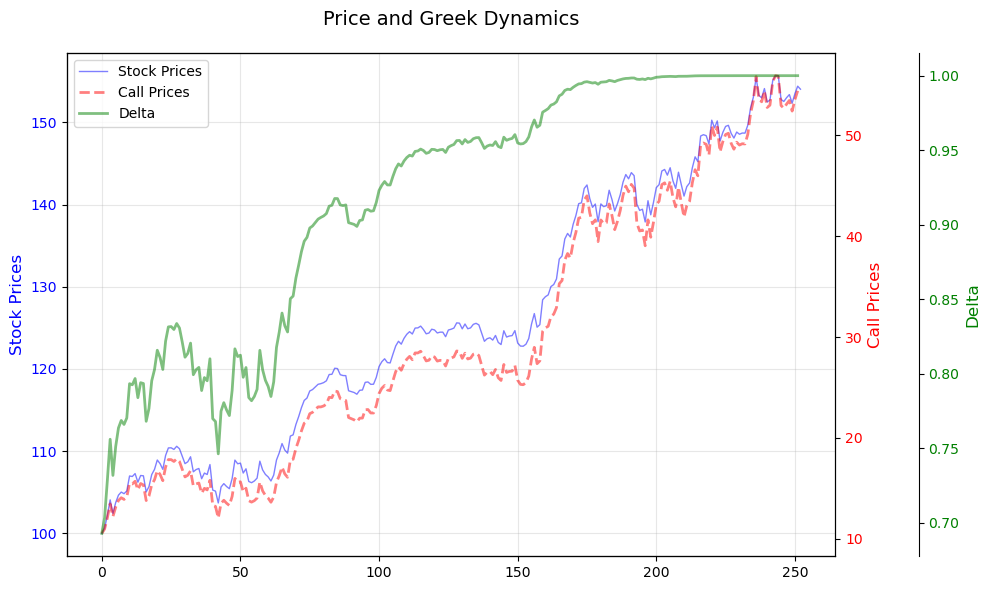

In [19]:
# Create triple-axis visualization for selected path
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(stock_prices[:, i], 'b-', label='Stock Prices', alpha=0.5, linewidth=1)
ax1.set_ylabel('Stock Prices', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(call_prices[:, i], 'r--', label='Call Prices', alpha=0.5, linewidth=2)
ax2.set_ylabel('Call Prices', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.plot(call_delta[:, i], 'g-', label='Delta', alpha=0.5, linewidth=2)
ax3.set_ylabel('Delta', color='g', fontsize=12)
ax3.tick_params(axis='y', labelcolor='g')

ax3.spines['right'].set_position(('outward', 60))

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3,
           loc='upper left', fontsize=10)

plt.title('Price and Greek Dynamics', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


## Buyer's Profit Analysis

### Option Account Performance
- Tracks value of long call position
- Compares initial vs final account value
- Calculates absolute profit/loss


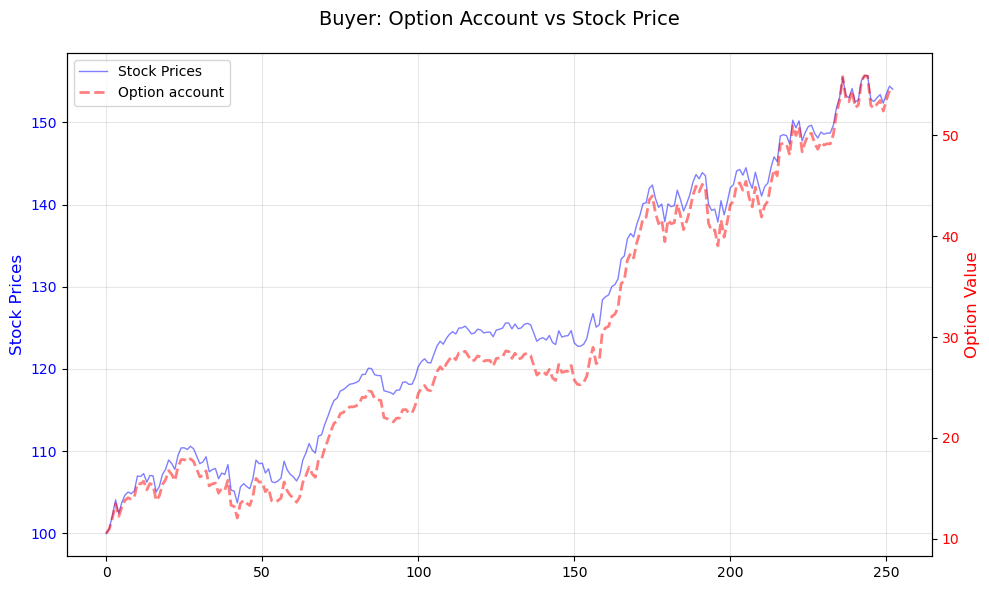

Initial account: 10.52
Final account: 54.42
Final profit: 43.90


In [20]:
# Plot buyer's option account performance
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(stock_prices[:, i], 'b-', label='Stock Prices', alpha=0.5, linewidth=1)
ax1.set_ylabel('Stock Prices', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(option_account[:, i], 'r--', label='Option account', alpha=0.5, linewidth=2)
ax2.set_ylabel('Option Value', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.title('Buyer: Option Account vs Stock Price', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print(f'Initial account: {option_account[0, i]:.2f}')
print(f'Final account: {option_account[-1, i]:.2f}')
print(f'Final profit: {max(option_account[-1, i] - option_account[0, i], -option_account[0, i]):.2f}')


## Seller's Hedge Performance

### Combined Stock and Cash Account Tracking
- Stock account: Short position value
- Cash account: Funding and rebalancing
- Right axis offset for clarity
- Terminal value depends on exercise outcome


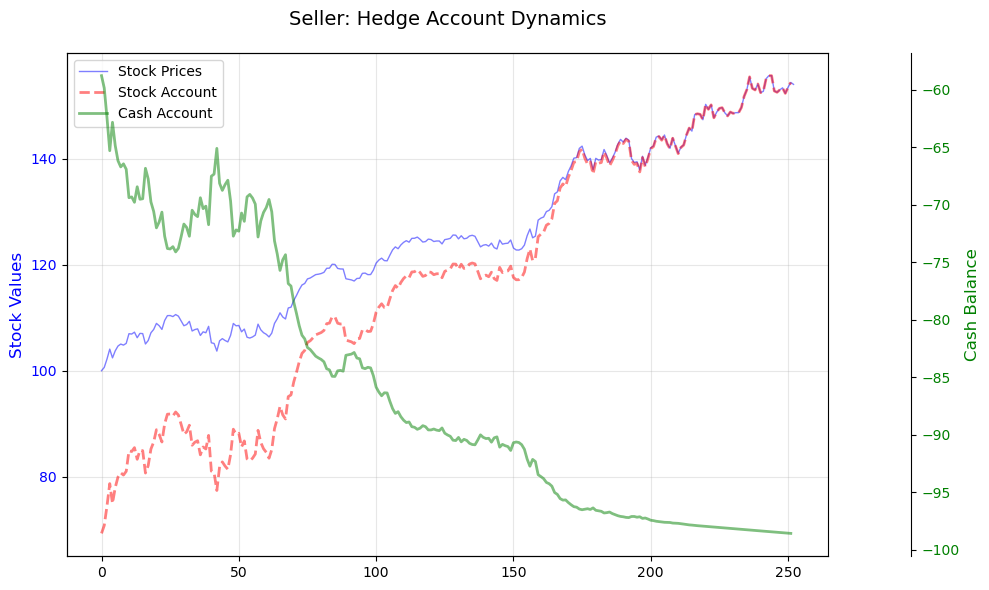

In [21]:
# Visualize seller's hedge components
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(stock_prices[:, i], 'b-', label='Stock Prices', alpha=0.5, linewidth=1)
ax1.plot(-stock_account[:, i], 'r--', label='Stock Account', alpha=0.5, linewidth=2)
ax1.set_ylabel('Stock Values', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, alpha=0.3)

ax3 = ax1.twinx()
ax3.plot(-cash_account[:, i], 'g-', label='Cash Account', alpha=0.5, linewidth=2)
ax3.set_ylabel('Cash Balance', color='g', fontsize=12)
ax3.tick_params(axis='y', labelcolor='g')
ax3.spines['right'].set_position(('outward', 60))

lines1, labels1 = ax1.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines3, labels1 + labels3, loc='upper left', fontsize=10)

plt.title('Seller: Hedge Account Dynamics', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


In [22]:
# Print seller's terminal PnL calculation
print('Initial State:')
print(f'Option premium received: {option_account[0, i]:.2f}')
print(f'Initial stock position: {-stock_account[0, i]:.2f}')
print(f'Initial cash balance: {-cash_account[0, i]:.2f}')
print(f'Total initial: {-(stock_account[0, i] + cash_account[0, i]):.2f}')

print('\nTerminal State:')
print(f'Final stock position: {-stock_account[-1, i]:.2f}')
print(f'Final cash balance: {-cash_account[-1, i]:.2f}')
print(f'Gross position: {-stock_account[-1, i] - cash_account[-1, i]:.2f}')

if stock_prices[-1, i] > strike:
    print('\nOption Exercised:')
    print(f'Final profit = {(-cash_account[-1, i] + strike):.2f} (cash + strike received)')
else:
    print('\nOption Expired Worthless:')
    print(f'Final profit = {(-stock_account[-1, i] - cash_account[-1, i]):.2f}')


Initial State:
Option premium received: 10.52
Initial stock position: 69.30
Initial cash balance: -58.78
Total initial: 10.52

Terminal State:
Final stock position: 154.39
Final cash balance: -98.58
Gross position: 55.82

Option Exercised:
Final profit = 1.42 (cash + strike received)


## Example 2 stock price < 80

In [23]:
# Find first path where terminal stock price < 80
for i in range(1000):
    if stock_prices[-1, i] < 80:
        print(f'Path {i}, Final stock price i = : {stock_prices[-1, i]:.2f}')
        break


Path 31, Final stock price i = : 77.09


## Visualizing Price and Greek Relationships
#
### Combined Plot: Stock Price, Option Price, and Delta
- Primary axis: Stock price movement (blue)
- Secondary axis: Option price (red dashed)
- Tertiary axis: Delta values (green)
- Demonstrates dynamic relationship between metrics
#

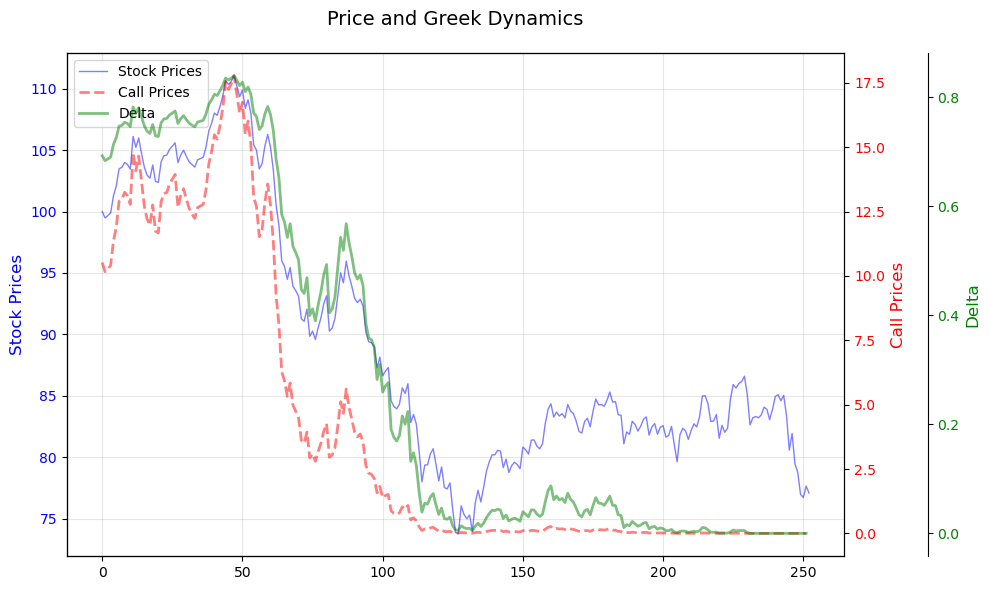

In [24]:
# Create triple-axis visualization for selected path
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(stock_prices[:, i], 'b-', label='Stock Prices', alpha=0.5, linewidth=1)
ax1.set_ylabel('Stock Prices', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(call_prices[:, i], 'r--', label='Call Prices', alpha=0.5, linewidth=2)
ax2.set_ylabel('Call Prices', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.plot(call_delta[:, i], 'g-', label='Delta', alpha=0.5, linewidth=2)
ax3.set_ylabel('Delta', color='g', fontsize=12)
ax3.tick_params(axis='y', labelcolor='g')

ax3.spines['right'].set_position(('outward', 60))

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3,
           loc='upper left', fontsize=10)

plt.title('Price and Greek Dynamics', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


## Buyer's Profit Analysis
#
### Option Account Performance
- Tracks value of long call position
- Compares initial vs final account value
- Calculates absolute profit/loss
#

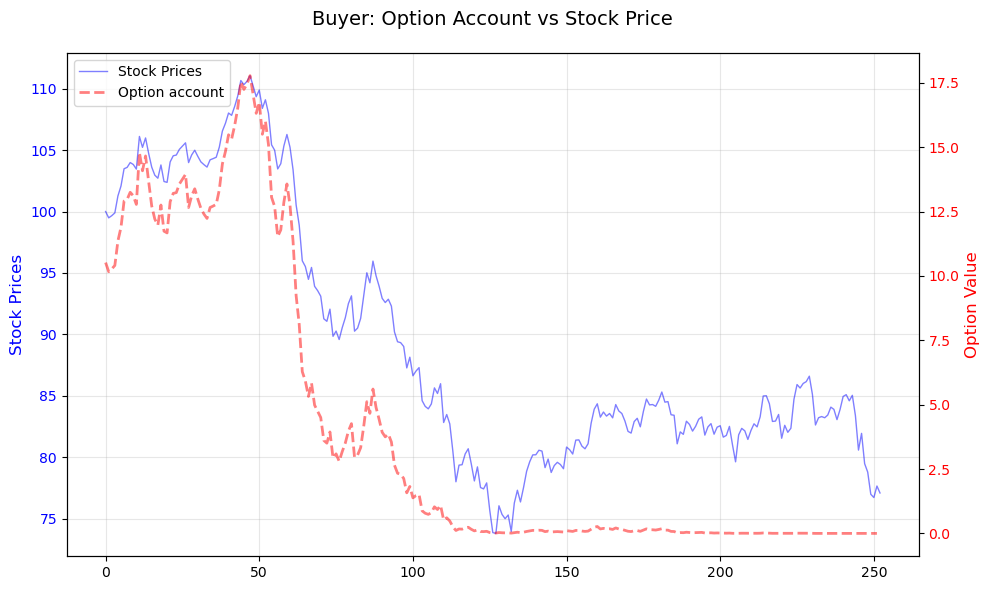

Initial account: 10.52
Final account: 0.00
Final profit: -10.52


In [25]:
# Plot buyer's option account performance
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(stock_prices[:, i], 'b-', label='Stock Prices', alpha=0.5, linewidth=1)
ax1.set_ylabel('Stock Prices', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(option_account[:, i], 'r--', label='Option account', alpha=0.5, linewidth=2)
ax2.set_ylabel('Option Value', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.title('Buyer: Option Account vs Stock Price', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print(f'Initial account: {option_account[0, i]:.2f}')
print(f'Final account: {option_account[-1, i]:.2f}')
print(f'Final profit: {max(option_account[-1, i] - option_account[0, i], -option_account[0, i]):.2f}')


## Seller's Hedge Performance
#
### Combined Stock and Cash Account Tracking
- Stock account: Short position value
- Cash account: Funding and rebalancing
- Right axis offset for clarity
- Terminal value depends on exercise outcome
#

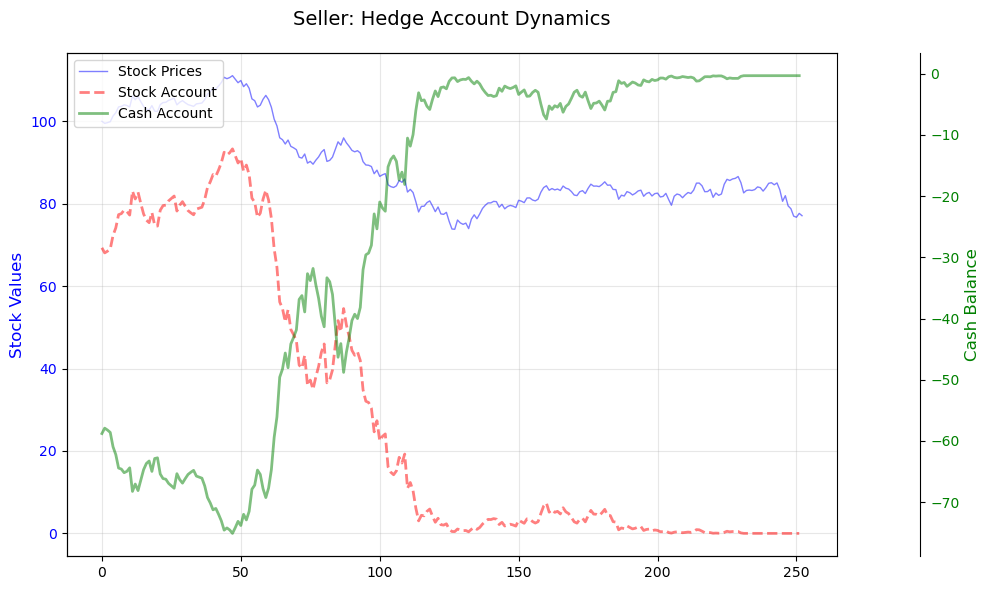

In [26]:
# Visualize seller's hedge components
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(stock_prices[:, i], 'b-', label='Stock Prices', alpha=0.5, linewidth=1)
ax1.plot(-stock_account[:, i], 'r--', label='Stock Account', alpha=0.5, linewidth=2)
ax1.set_ylabel('Stock Values', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, alpha=0.3)

ax3 = ax1.twinx()
ax3.plot(-cash_account[:, i], 'g-', label='Cash Account', alpha=0.5, linewidth=2)
ax3.set_ylabel('Cash Balance', color='g', fontsize=12)
ax3.tick_params(axis='y', labelcolor='g')
ax3.spines['right'].set_position(('outward', 60))

lines1, labels1 = ax1.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines3, labels1 + labels3, loc='upper left', fontsize=10)

plt.title('Seller: Hedge Account Dynamics', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


In [27]:
# Print seller's terminal PnL calculation
print('Initial State:')
print(f'Option premium received: {option_account[0, i]:.2f}')
print(f'Initial stock position: {-stock_account[0, i]:.2f}')
print(f'Initial cash balance: {-cash_account[0, i]:.2f}')
print(f'Total initial: {-(stock_account[0, i] + cash_account[0, i]):.2f}')

print('\nTerminal State:')
print(f'Final stock position: {-stock_account[-1, i]:.2f}')
print(f'Final cash balance: {-cash_account[-1, i]:.2f}')
print(f'Gross position: {-stock_account[-1, i] - cash_account[-1, i]:.2f}')

if stock_prices[-1, i] > strike:
    print('\nOption Exercised:')
    print(f'Final profit = {(-cash_account[-1, i] + strike):.2f} (cash + strike received)')
else:
    print('\nOption Expired Worthless:')
    print(f'Final profit = {(-stock_account[-1, i] - cash_account[-1, i]):.2f}')


Initial State:
Option premium received: 10.52
Initial stock position: 69.30
Initial cash balance: -58.78
Total initial: 10.52

Terminal State:
Final stock position: 0.00
Final cash balance: -0.31
Gross position: -0.31

Option Expired Worthless:
Final profit = -0.31


## Example 3 stock price > 95 and stock price < 105

In [28]:
# Find first path where terminal stock price > 95 and stock price < 105
for i in range(1000):
    if stock_prices[-1, i] > 95 and stock_prices[-1, i] < 105:
        print(f'Path {i}, Final stock price i = : {stock_prices[-1, i]:.2f}')
        break


Path 0, Final stock price i = : 98.91


## Visualizing Price and Greek Relationships
#
### Combined Plot: Stock Price, Option Price, and Delta
- Primary axis: Stock price movement (blue)
- Secondary axis: Option price (red dashed)
- Tertiary axis: Delta values (green)
- Demonstrates dynamic relationship between metrics
#

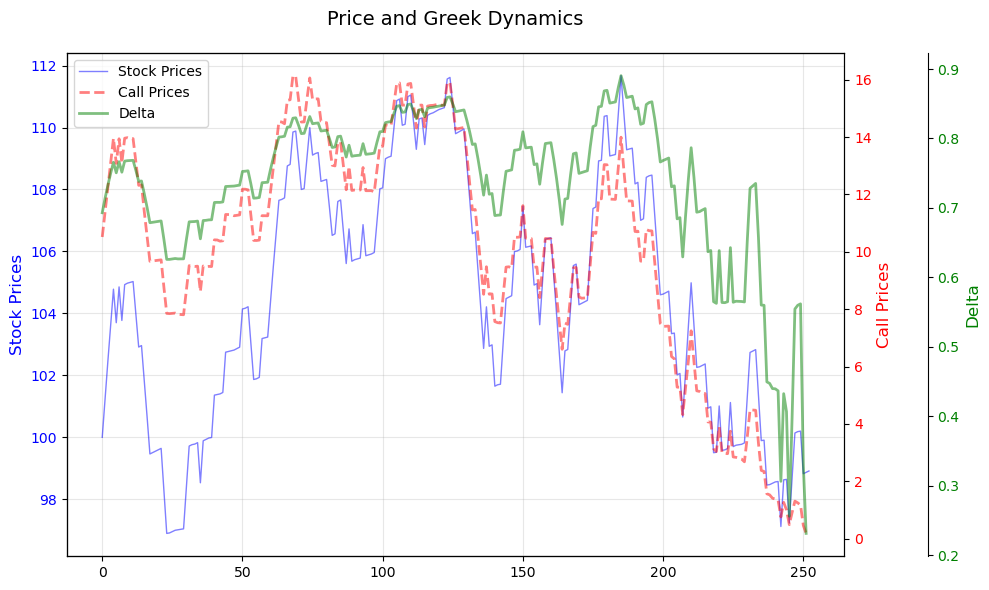

In [29]:
# Create triple-axis visualization for selected path
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(stock_prices[:, i], 'b-', label='Stock Prices', alpha=0.5, linewidth=1)
ax1.set_ylabel('Stock Prices', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(call_prices[:, i], 'r--', label='Call Prices', alpha=0.5, linewidth=2)
ax2.set_ylabel('Call Prices', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.plot(call_delta[:, i], 'g-', label='Delta', alpha=0.5, linewidth=2)
ax3.set_ylabel('Delta', color='g', fontsize=12)
ax3.tick_params(axis='y', labelcolor='g')

ax3.spines['right'].set_position(('outward', 60))

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3,
           loc='upper left', fontsize=10)

plt.title('Price and Greek Dynamics', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


## Buyer's Profit Analysis
#
### Option Account Performance
- Tracks value of long call position
- Compares initial vs final account value
- Calculates absolute profit/loss
#

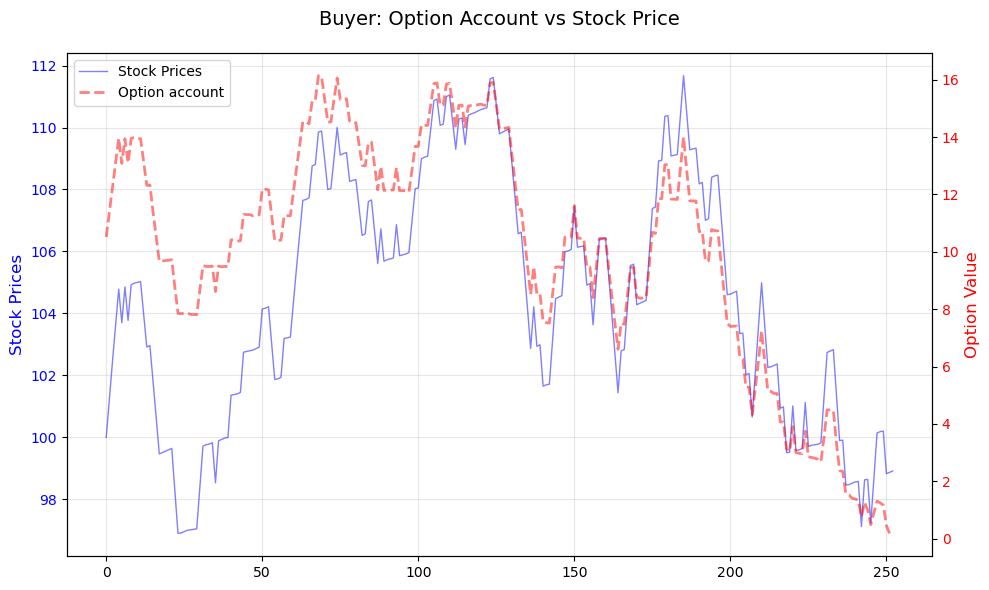

Initial account: 10.52
Final account: 0.19
Final profit: -10.33


In [30]:
# Plot buyer's option account performance
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(stock_prices[:, i], 'b-', label='Stock Prices', alpha=0.5, linewidth=1)
ax1.set_ylabel('Stock Prices', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(option_account[:, i], 'r--', label='Option account', alpha=0.5, linewidth=2)
ax2.set_ylabel('Option Value', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.title('Buyer: Option Account vs Stock Price', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print(f'Initial account: {option_account[0, i]:.2f}')
print(f'Final account: {option_account[-1, i]:.2f}')
print(f'Final profit: {max(option_account[-1, i] - option_account[0, i], -option_account[0, i]):.2f}')


## Seller's Hedge Performance
#
### Combined Stock and Cash Account Tracking
- Stock account: Short position value
- Cash account: Funding and rebalancing
- Right axis offset for clarity
- Terminal value depends on exercise outcome
#

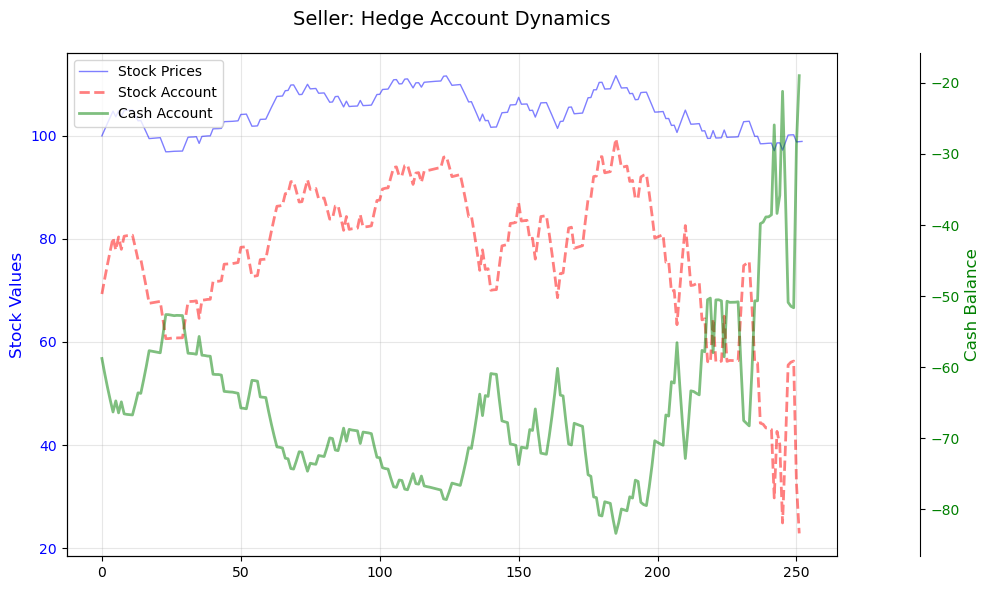

In [31]:
# Visualize seller's hedge components
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(stock_prices[:, i], 'b-', label='Stock Prices', alpha=0.5, linewidth=1)
ax1.plot(-stock_account[:, i], 'r--', label='Stock Account', alpha=0.5, linewidth=2)
ax1.set_ylabel('Stock Values', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, alpha=0.3)

ax3 = ax1.twinx()
ax3.plot(-cash_account[:, i], 'g-', label='Cash Account', alpha=0.5, linewidth=2)
ax3.set_ylabel('Cash Balance', color='g', fontsize=12)
ax3.tick_params(axis='y', labelcolor='g')
ax3.spines['right'].set_position(('outward', 60))

lines1, labels1 = ax1.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines3, labels1 + labels3, loc='upper left', fontsize=10)

plt.title('Seller: Hedge Account Dynamics', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


In [32]:
# Print seller's terminal PnL calculation
print('Initial State:')
print(f'Option premium received: {option_account[0, i]:.2f}')
print(f'Initial stock position: {-stock_account[0, i]:.2f}')
print(f'Initial cash balance: {-cash_account[0, i]:.2f}')
print(f'Total initial: {-(stock_account[0, i] + cash_account[0, i]):.2f}')

print('\nTerminal State:')
print(f'Final stock position: {-stock_account[-1, i]:.2f}')
print(f'Final cash balance: {-cash_account[-1, i]:.2f}')
print(f'Gross position: {-stock_account[-1, i] - cash_account[-1, i]:.2f}')

if stock_prices[-1, i] > strike:
    print('\nOption Exercised:')
    print(f'Final profit = {(-cash_account[-1, i] + strike):.2f} (cash + strike received)')
else:
    print('\nOption Expired Worthless:')
    print(f'Final profit = {(-stock_account[-1, i] - cash_account[-1, i]):.2f}')


Initial State:
Option premium received: 10.52
Initial stock position: 69.30
Initial cash balance: -58.78
Total initial: 10.52

Terminal State:
Final stock position: 22.85
Final cash balance: -18.98
Gross position: 3.87

Option Expired Worthless:
Final profit = 3.87
